In [20]:
import cv2
import matplotlib.pyplot as plt
from consts import HERE, SAMPLING_RATE_LFP
import numpy as np
import napari
from utils import norm

In [21]:
def save_video() -> None:
    cap = cv2.VideoCapture(str(HERE.parent / "data" / "eyeCamleft.mj2"))

    video = []
    while(cap.isOpened()):
        _, frame = cap.read()
        if frame is None:
            break
        video.append(frame[:, : ,0])

    video = np.array(video)
    np.save(HERE.parent / "data" / "long_video.npy", video)

In [22]:

video = np.load(HERE.parent / "data" / "long_video.npy")
viewer = napari.Viewer()
viewer.add_image(video, name="pupil")

<Image layer 'pupil' at 0x2814be950>

In [23]:
shape = [layer for layer in viewer.layers if layer.name == "Shapes"][0]


IndexError: list index out of range

In [8]:

x_min = shape.corner_pixels[0][1]
y_min = shape.corner_pixels[0][2]

x_max = shape.corner_pixels[1][1]
y_max = shape.corner_pixels[1][2]


In [9]:
cropped = video[:, x_min:x_max, y_min:y_max]

viewer.add_image(cropped, name="cropped")

<Image layer 'cropped' at 0x281403790>

In [10]:
cropped.shape

(17346, 47, 67)

In [17]:
fps = 30
out = cv2.VideoWriter('croppedPupil.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (cropped.shape[2], cropped.shape[1]), False)
for frame in range(cropped.shape[0]):
    out.write(cropped[frame, :, :])
out.release()

In [21]:
diffed = np.abs(np.diff(cropped, axis=0))
diffed.shape

(17345, 38, 54)

In [25]:

import csv
import sys

csv.field_size_limit(sys.maxsize)

with open("/Volumes/MarcBusche/Qichen/Neuropixels/ELGH11144/Processed/Baseline1/Pupil_size.csv", newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    row = next(reader)
    lst = row[0].split(",")

pupil = np.array([float(v) for v in lst])
pupil[pupil > 10000] = 0

In [26]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [27]:
slow_wave = np.load(HERE.parent / "data" / "slow_wave.npy")
# slow_wave_xaxis = np.load(HERE.parent / "data" / "slow_wave_xaxis.npy")
step = SAMPLING_RATE_LFP * 0.1

slow_wave = moving_average(slow_wave, 10)

slow_wave_xaxis = np.arange(0, len(slow_wave) * step / SAMPLING_RATE_LFP, step / SAMPLING_RATE_LFP)

In [28]:
from scipy.stats import zscore
# plt.plot(np.arange(0, diffed.shape[0]) / 30, zscore(np.mean(np.abs(diffed), axis=(1, 2))))
# plt.plot(np.arange(0, pupil.shape[0]) / 30, zscore(pupil))
plt.figure()

diff_final = moving_average(zscore(np.mean(np.abs(diffed), axis=(1, 2))), 100)

x_pupil = np.arange(0, pupil.shape[0]) / 30
plt.plot(np.arange(0, diff_final.shape[0]) / 30, diff_final, label="Movement diff")
plt.plot(x_pupil, zscore(pupil) * -1, label="Pupil size")

plt.plot(slow_wave_xaxis, slow_wave, label="Slow wave")

np.save(HERE.parent / "data" / "diff_final.npy", diff_final)
np.save(HERE.parent / "data" / "pupil.npy", pupil)
plt.legend()

plt.savefig(HERE.parent / "figures" / "Pupil_and_diff_andslowwave.png")

NameError: name 'diffed' is not defined

<Figure size 640x480 with 0 Axes>

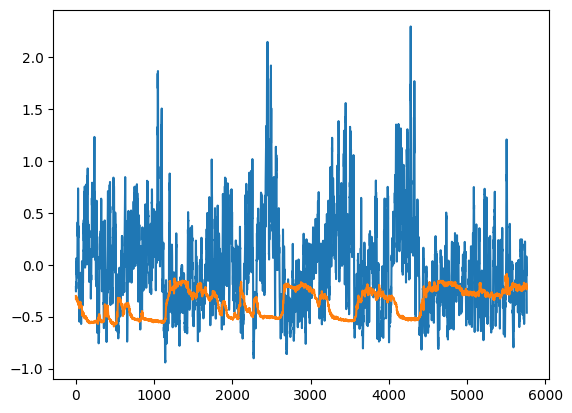

In [29]:
from scipy.signal import resample, correlate

pupil_downsampled = resample(pupil, len(slow_wave))
plt.plot(slow_wave)
plt.plot(pupil_downsampled * -1)

In [38]:
import pandas as pd


pupil_dlc = pd.read_csv("/Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB/pupil/PD_ratio10Hz.csv", header=None).to_numpy().squeeze()

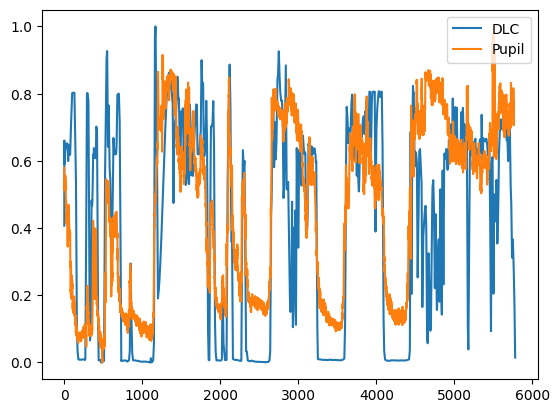

In [45]:
plt.plot(pupil_dlc, label="DLC")
plt.plot(norm(pupil_downsampled * -1), label="Pupil")
plt.legend()

In [46]:
pupil_velocity = pd.read_csv("/Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB/pupil/Pupil_velocity10Hz.csv", header=None).to_numpy().squeeze()

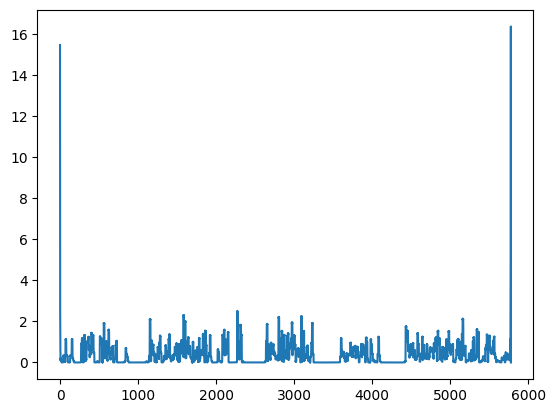

In [47]:
plt.plot(pupil_velocity)

In [75]:
np.corrcoef(pupil_downsampled * -1, slow_wave)

array([[ 1.        , -0.49264409],
       [-0.49264409,  1.        ]])

In [69]:
shuffled = np.random.permutation(pupil_downsampled)

In [71]:
from utils import shuffle

np.corrcoef(shuffled, slow_wave)

array([[1.       , 0.0056548],
       [0.0056548, 1.       ]])

In [53]:
slow_wave.shape

(5764,)

In [54]:
pupil.shape

(17346,)